In [1]:
# !conda create -n crewai python=3.11
# !conda activate crewai -
%pip install -U 'crewai[tools]' mdpdf 

%pip install langchain_google_vertexai

In [2]:
import re

PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

SVC_ACC = !(gcloud config get-value core/account)
SVC_ACC = SVC_ACC[0]

PROJECT_NUMBER=str(re.search(r'\d+', SVC_ACC).group())

LOCATION="asia-southeast1"

FOLDER_NAME="."

In [3]:
from crewai import Agent, Task, Crew, Process
from crewai_tools import tool
from crewai_tools.tools import FileReadTool
import os, requests, re, mdpdf, subprocess

from langchain_community.vectorstores import Chroma
from langchain_community.tools import DuckDuckGoSearchRun

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/jupyter/.config/sagemaker/config.yaml


/opt/conda/envs/pytorch/lib/python3.10/site-packages/langchain_community/tools/ddg_search/__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.tools.ddg_search.tool import DuckDuckGoSearchRun


#### If facing Error 

comment out OpenAI models  in this python file

/opt/conda/envs/pytorch/lib/python3.10/site-packages/embedchain/app.py

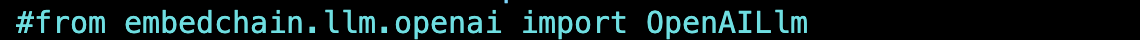

and

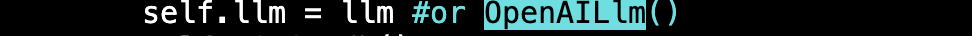


In [4]:
# %pip install --upgrade --quiet  langchain-core langchain-google-vertexai
# %pip install mdpdf

In [5]:
# ! mdpdf -o output.pdf story.md

In [10]:
from crewai import Agent, Task, Crew, Process
from crewai_tools import tool
# from langchain_vertexai import ChatGemini
from crewai_tools.tools import FileReadTool
import os, requests, re, mdpdf, subprocess
from vertexai.preview.vision_models import ImageGenerationModel
from langchain_google_vertexai import ChatVertexAI
import uuid, os

# Initialize Gemini LLM
llm = ChatVertexAI(
    model_name='gemini-1.5-pro-002', #"gemini-1.0-pro-002", # Replace with your desired Gemini model
    project_id=os.getenv(PROJECT_ID), # Your Vertex AI project ID
    location="us-central1", # Your Vertex AI location
)

# Initialize Imagen model

@tool
def generateimage(chapter_content_and_character_details: str) -> str:
    """
    Generates an image using Imagen for a given chapter content and character details and return the image_url.
    """
    image_generation_model = ImageGenerationModel.from_pretrained("imagegeneration@006")

    chapter_content_and_character_details_refined = generate_pro(chapter_content_and_character_details)
    
    prompt = f"Image is about: {chapter_content_and_character_details_refined}. Style: Illustration. Create an illustration incorporating a vivid palette with an emphasis on shades of azure and emerald, augmented by splashes of gold for contrast and visual interest. The style should evoke the intricate detail and whimsy of early 20th-century storybook illustrations, blending realism with fantastical elements to create a sense of wonder and enchantment. The composition should be rich in texture, with a soft, luminous lighting that enhances the magical atmosphere. Attention to the interplay of light and shadow will add depth and dimensionality, inviting the viewer to delve into the scene. DON'T include ANY text in this image. DON'T include colour palettes in this image."

    response = image_generation_model.generate_images(
        prompt=prompt,
        aspect_ratio="1:1",
        number_of_images=1,
        safety_filter_level="block_few",
        person_generation="allow_adult",
    )
    
    # image_url = response.images[0].url
    image_url_name = str(uuid.uuid4())
    
    filepath = os.path.join(os.getcwd(), "images1/")

    image_url = filepath+image_url_name+".jpg"
    response.images[0].save(location=image_url)
    print("url",image_url)

    return(image_url)

In [11]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part



def generate_pro(input_prompt):
    model = GenerativeModel("gemini-1.5-pro-preview-0514") #gemini-1.0-pro-002") #gemini-1.5-pro-preview-0409
    full_prompt = '''summarize the prompt below and do note prompt below will be send to imagen model to create images  so please clean up any sensitve words and replace them into unblocked words like replace girl or lady can be replaced by female human and remove any names to make the prompt simple and easy  : ''' + input_prompt
    responses = model.generate_content(
    input_prompt,
    generation_config={
        "max_output_tokens": 1024,
        "temperature": 0.2,
        "top_p": 1
    },stream=False,)
    
    # print (responses.text)
    
    return(responses.text)


# input_prompt = '''
# Action 'generateimage(chapter_content_and_character_details={'chapter_content': 'Panic ensued in the animal kingdom as Professor Hoot, the wise old owl, was called upon to investigate. The mystery deepened as they searched for clues to unravel the enigma of Zeke's missing stripes.', 'character_details': 'Professor Hoot is a wise old owl'})' don't exist, these are the only available Actions: generateimage: generateimage(chapter_content_and_character_details: 'string') -      Generates an image using Imagen for a given chapter content and character details.     

# '''

# generate_pro(input_prompt)

In [12]:
# generateimage("human female walking on road")
# image_url_name = str(uuid.uuid4())
# filepath=os.path.join(os.getcwd(), "images1/")
# image_url = filepath+image_url_name+".png"
# print(image_url)

# image_response = requests.get(image_url)
# if image_response.status_code == 200:
#     with open(filepath, 'wb') as file:
#         file.write(image_response.content)
# else:
#     print("Failed to download the image.")
    # return ""

In [ ]:
# Instantiate tools
file_read_tool = FileReadTool(
	file_path='template.md',
	description='A tool to read the Story Template file and understand the expected output format.'
)

search_tool = DuckDuckGoSearchRun()


@tool
def convermarkdowntopdf(markdownfile_name: str) -> str:
    """
    Converts a Markdown file to a PDF document using the mdpdf command line application.

    Args:
        markdownfile_name (str): Path to the input Markdown file.

    Returns:
        str: Path to the generated PDF file.
    """
    output_file = os.path.splitext(markdownfile_name)[0] + '.pdf'
    
    # Command to convert markdown to PDF using mdpdf
    cmd = ['mdpdf', '--output', output_file, markdownfile_name]
    
    # Execute the command
    subprocess.run(cmd, check=True)
    
    return output_file

story_outliner = Agent(
  role='Story Outliner',
  goal='Develop an outline for a children\'s storybook about Animals, including chapter titles and characters for 5 chapters.',
  backstory="An imaginative creator who lays the foundation of captivating stories for children.",
  verbose=True,
  llm=llm,
  allow_delegation=False
)

story_writer = Agent(
  role='Story Writer',
  goal='Write the full content of the story for all 5 chapters, each chapter 300 words, weaving together the narratives and characters outlined.',
  backstory="A talented storyteller who brings to life the world and characters outlined, crafting engaging and imaginative tales for children.",
  verbose=True,
  llm=llm,
  allow_delegation=False
)

image_generator = Agent(
  role='Image Generator',
  goal='Generate one image per chapter content provided by the story outliner. Start with Chapter number, chapter content, character details, detailed location information and detailed items in the location where the activity happens. Generate totally 5 images one by one. Final output should contain all the 5 images in json format.',
  backstory="A creative AI specialized in visual storytelling, bringing each chapter to life through imaginative imagery.",
  verbose=True,
  llm=llm,
  tools=[generateimage],
  allow_delegation=False
)

content_formatter = Agent(
    role='Content Formatter',
    goal='Format the written story content in markdown, including images at the beginning of each chapter.',
    backstory='A meticulous formatter who enhances the readability and presentation of the storybook.',
    verbose=True,
    llm=llm,
    tools=[file_read_tool],
    allow_delegation=False
)

markdown_to_pdf_creator = Agent(
    role='PDF Converter',
    goal='Convert the Markdown file to a PDF document. story.md is the markdown file name.',
    backstory='An efficient converter that transforms Markdown files into professionally formatted PDF documents.',
    verbose=True,
    llm=llm,
    tools=[convermarkdowntopdf],
    allow_delegation=False
)


# Create tasks for the agents
task_outline = Task(
    description='Create an outline for the children\'s storybook about Animals, detailing chapter titles and character descriptions for 5 chapters.',
    agent=story_outliner,
    expected_output='A structured outline document containing 5 chapter titles, with detailed character descriptions and the main plot points for each chapter.'
)

task_write = Task(
    description='Using the outline provided, write the full story content for all chapters, ensuring a cohesive and engaging narrative for children. Each Chapter 100 words. Include Title of the story at the top.',
    agent=story_writer,
    expected_output='A complete manuscript of the children\'s storybook about Animals with 5 chapters. Each chapter should contain approximately 100 words, following the provided outline and integrating the characters and plot points into a cohesive narrative.'
)

task_image_generate = Task(
    description='Generate 5 images that captures the essence of the children\'s storybook about Animals, aligning with the themes, characters, and narrative outlined for the chapters. Do it one by one.',
    agent=image_generator,
    expected_output='A digital image file that visually represents the overarching theme of the children\'s storybook, incorporating elements from the characters and plot as described in the outline. The image should be suitable for inclusion in the storybook as an illustration.',
)

task_format_content = Task(
    description='Format the story content in markdown, including an image at the beginning of each chapter.',
    agent=content_formatter,
    expected_output='The entire storybook content formatted in markdown, with each chapter title followed by the corresponding image and the chapter content.',
    context=[task_write, task_image_generate],
    output_file="story.md"
)

task_markdown_to_pdf = Task(
    description='Convert a Markdown file to a PDF document, ensuring the preservation of formatting, structure, and embedded images using the mdpdf library.',
    agent=markdown_to_pdf_creator,
    expected_output='A PDF file generated from the Markdown input, accurately reflecting the content with proper formatting. The PDF should be ready for sharing or printing.'
)

crew = Crew(
  agents=[story_outliner, story_writer, image_generator, content_formatter, markdown_to_pdf_creator],
  tasks=[task_outline, task_write, task_image_generate, task_format_content, task_markdown_to_pdf],
  verbose=True,
  process=Process.sequential
)

result = crew.kickoff()

print(result)


2024-10-09 04:26:50,102 - 139887101867200 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


# Agent: Story Outliner
## Task: Create an outline for the children's storybook about Animals, detailing chapter titles and character descriptions for 5 chapters.


# Agent: Story Outliner
## Final Answer: 
**Title:** The Great Forest Feast

**Overall Story Arc:** A group of animal friends discovers a hidden map leading to a legendary feast hidden deep within the forest.  They embark on a journey, facing challenges and learning valuable lessons about teamwork and friendship along the way.

**Chapter 1: The Whispering Map**

*   **Characters:**
    *   **Barnaby Bear:** A curious and adventurous young bear cub.
    *   **Fiona Fox:** A clever and resourceful fox kit.
    *   **Ollie Owl:** A wise but slightly clumsy owl.
*   **Plot:** Barnaby discovers a tattered map hidden in his attic. Fiona deciphers its clues, revealing a hidden feast somewhere in the forest. They decide to embark on an adventure to find it, inviting Ollie to join them.

**Chapter 2:  Through the Tangled Woods**

* 